<a href="https://colab.research.google.com/github/kap2fox/Intro-to-Robotics/blob/main/Motor_identification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Идентификация параметров
После проведения эксперимента, стоит сравнить полученные данные с рассчитанным поведением математической модели. Для этого нужно считать показания угла поворота и таймера из файла, загрузив сам файл в рабочее пространство.

In [ ]:
from google.colab import files    # импорт модуля для работы с файлам
uploaded = files.upload()         # запуск функции загрузки файлов из локального диска

Saving data.txt to data.txt


Используя функцию *loadtxt* из модуля *numpy*, получаем массивы значений угла поворота и времени. Следующим шагом нужно привести показания переменных в систему СИ, чтобы получить неизвестные коэффициенты нужной размерности.

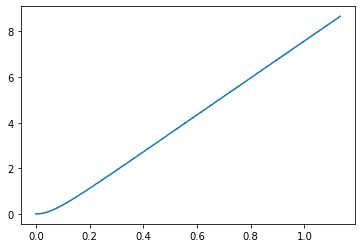

In [ ]:
import numpy as np                  # модуль для поддержки многомерных массивов
import matplotlib.pyplot as plt     # модуль для визуализации данных
from scipy import optimize          # модуль для оптимизации функций
from scipy.integrate import odeint  # функция для решения дифференциальных уравнений
time, angle = np.loadtxt('data.txt',delimiter=' ',dtype=[('f0',float),('f1',float)], usecols=(0, 1), unpack=True) #считывание времени и угла из файла
time = (time -time[0]) / 1000       # приведение к системе СИ
angle = angle * np.pi / 360         # приведение к системе СИ
plt.plot(time, angle)               # изображение графика

Далее необходимо определить функцию угла поворота двигателя для нахождения оптимальных значений $T_m$ и $k_e$. Имея описанную модель и реальные измерения угла поворота от времени, можно воспользоваться функцией *optimize.curve_fit* с начальными условиями поиска значений *p0*.

In [ ]:
def model(t, speed, T_m):
    return speed * t- speed * T_m + speed * T_m * np.exp(- t / T_m) # определение функции угла поворота
popt, pcov = optimize.curve_fit(model, time, angle, p0=[8, 0.4])    # нахождение оптимальных коэффициентов функции
popt                                                                # вывод коэффициентов

array([8.11484867, 0.06530119])

Для наглядности сравним графики уравнения с найденными коэфициентами и экспериментальными измерениями. Можно заметить, что экспериментальный график разгоняется чуть медленнее, так как некоторые физические процессы не учитывались в модели. Прежде всего это трение и электромагнитная динамика, но это слабо влияет на вращение двигателя.

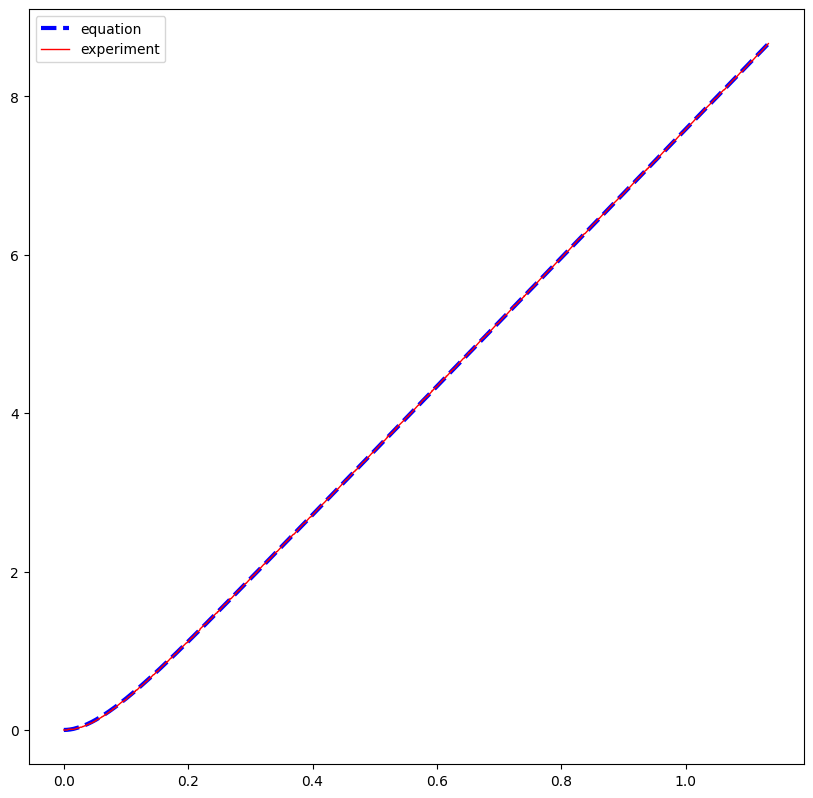

In [ ]:
equation = model(time, popt[0], popt[1])                            # вычисление значений функции с найденными коэффициентами
plt.figure(figsize=(10, 10), dpi=100)                               # указание размеров и разрешения окна графика
plt.plot (time, equation,'b--',linewidth=3,label='equation')        # изображение графика математической модели
plt.plot (time, angle,'r-',linewidth=1,label='experiment')          # изображение графика эксперимента
plt.legend()                                                        

Теперь нам нужно познакомиться с численным моделированием вращения двигателя. На следующих этапах нам нужно будет работать изменяющимся значением управляющего напряжения, оно будет пересчитываться на каждом такте работы программы. Первым делом нам необходимо определить численную модель двигателя, используя уравнение **3**:
$$
\left\{
    \begin{array}\\
        \dot\omega=\frac{U}{T_m k_e}-\frac{\omega}{T_m}, \\
        \dot\theta=\omega. 
    \end{array} \tag{5}
\right.
$$

In [ ]:
def motor(state,t):
    speed, angle = state                                            # обозначение состояния двигателя как скорости и угла поворота
    state_dt = np.array([-speed/T_m + u/ (T_m * k_e), speed ])      # задание производной состояния двигателя
    return state_dt

Функция *odeint* выдает численно проинтегрированный вывод модели. Мы задали его в виде пары чисел углового ускорения и угловой скорости, значит *odeint* позволит нам получить угловую скорость и угол поворота двигателя. Проверим это на графиках:

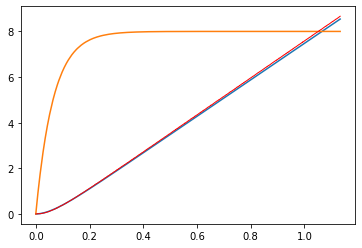

In [ ]:
T_m = popt[1]                                                       # электромеханическая постоянная времени
k_e = 0.5                                                           # конструктивная постоянная двигателя
u = 4                                                               # управляющее напряжение
init =[0,0]                                                         # начальные угол и угловая скорость
state = odeint(motor,init,time)                                     # численное решение дифференциального уравнения двигателя
plt.plot(time,state[:,1])                                           # изображение графика угла поврота
#plt.plot(time,state[:,0])                                          # изображение графика угловой скорости
plt.plot (time, angle,'r-',linewidth=1,label='experiment')          # изображение графика эксперимента